In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.layers import Dropout

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
BATCH_SIZE =25
IMAGE_SIZE = 854,480
CHANNELS=3
EPOCHS=3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"/content/gdrive/MyDrive/new",labels='inferred',shuffle=True)

Found 2096 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['allowed', 'notallowed']

In [7]:
for image_batch, labels_batch in dataset.take(1):
 print(image_batch.shape)
 print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1]


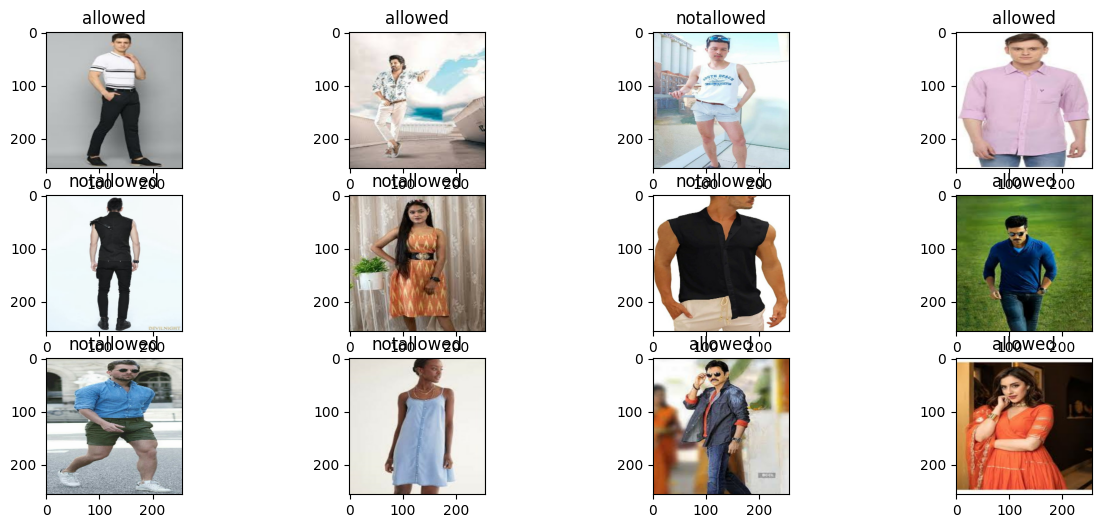

In [8]:
plt.figure(figsize=(15, 6))
for image_batch, labels_batch in dataset.take(1):
 for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title(class_names[labels_batch[i]])
  plt.axis("on")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8,  test_split=0.2, shuffle=True, shuffle_size=10):
    assert (train_split + test_split ) == 1
    ds_size = len(ds)
    if shuffle:
       ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    return train_ds, test_ds
train_ds,test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
layers.experimental.preprocessing.RandomRotation(0),
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = (BATCH_SIZE,256,256, CHANNELS)
n_classes = 2

In [17]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense
from tensorflow.keras import layers, models

input_shape = (256, 256, 3)
input_tensor = layers.Input(shape=input_shape)

# Stage 1
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Stage 2
shortcut = x

x = layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x)
x = layers.BatchNormalization()(x)

shortcut = layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same')(shortcut)
shortcut = layers.BatchNormalization()(shortcut)

x = layers.add([x, shortcut])
x = layers.Activation('relu')(x)

# Add more stages (Stage 3, 4, and 5) following a similar pattern...

# Output layer
x = layers.Flatten()(x)
output = layers.Dense(n_classes, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output)



In [18]:
model.save('resNet50.h5')

In [19]:
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 64  256        ['conv2d_15[0][0]']              
 ormalization)                  )                                                             

In [21]:
model.compile(
    optimizer='AdaDelta',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history=model.fit(
    train_ds,
    batch_size=32,
    verbose=1,
    epochs=100,
)

Epoch 1/100
52/52 [==============================] - 307s 4s/step - loss: 0.7367 - accuracy: 0.6364
Epoch 2/100
52/52 [==============================] - 15s 293ms/step - loss: 0.6344 - accuracy: 0.6941
Epoch 3/100
52/52 [==============================] - 15s 294ms/step - loss: 0.5618 - accuracy: 0.7254
Epoch 4/100
52/52 [==============================] - 15s 288ms/step - loss: 0.5037 - accuracy: 0.7656
Epoch 5/100
52/52 [==============================] - 15s 290ms/step - loss: 0.4453 - accuracy: 0.7819
Epoch 6/100
52/52 [==============================] - 15s 296ms/step - loss: 0.4186 - accuracy: 0.8107
Epoch 7/100
52/52 [==============================] - 15s 288ms/step - loss: 0.3838 - accuracy: 0.8323
Epoch 8/100
52/52 [==============================] - 16s 298ms/step - loss: 0.3675 - accuracy: 0.8383
Epoch 9/100
52/52 [==============================] - 15s 288ms/step - loss: 0.3294 - accuracy: 0.8648
Epoch 10/100
52/52 [==============================] - 15s 290ms/step - loss: 0.2995 

In [23]:
scores = model.evaluate(train_ds)

52/52 [==============================] - 14s 268ms/step - loss: 0.0059 - accuracy: 1.0000


In [24]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 6s 31ms/step - loss: 0.0115 - accuracy: 1.0000


In [25]:
scores

[0.011498242616653442, 1.0]

first image to predict
actual label: allowed
1/1 [==============================] - 0s 49ms/step
predicted label: allowed


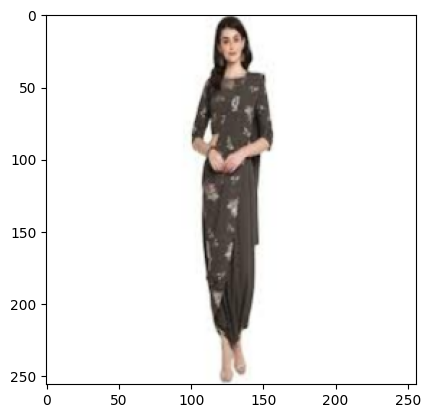

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[9].numpy().astype('uint8')
    first_label = labels_batch[9].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[9])])


In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


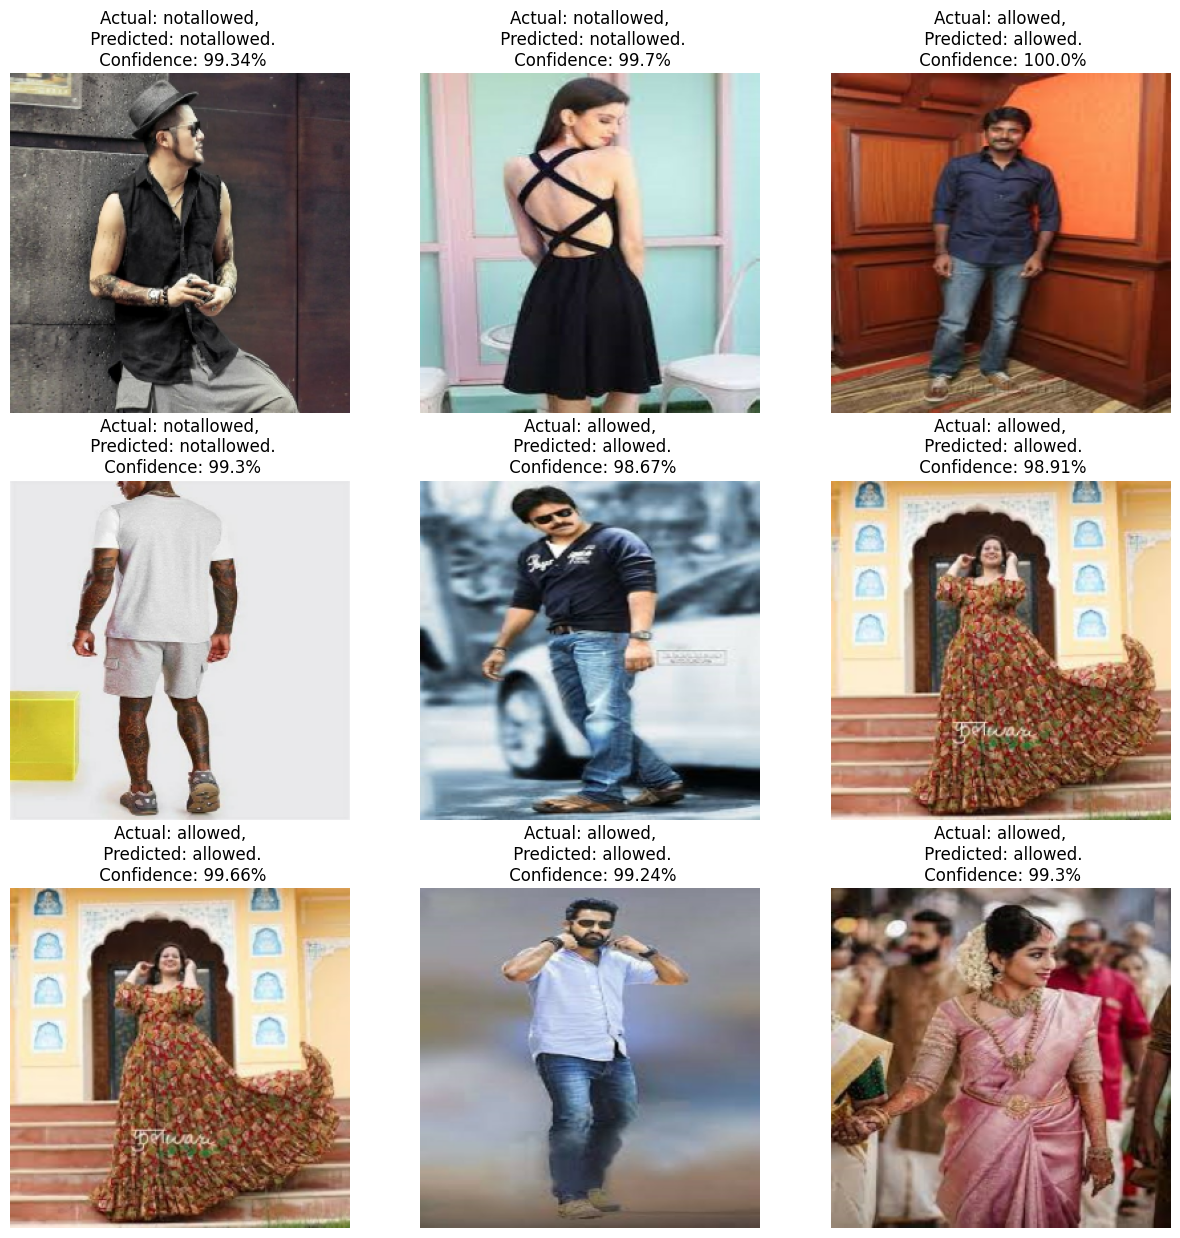

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      predicted_class, confidence = predict(model, images[i].numpy())
      actual_class = class_names[labels[i]]
      plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
      plt.axis("off")